# pySingleCellNetCalibrated: This Notebook performs 'cell typing', or classification of single cell RNA-Seq data.

In [2]:
# Different scenario for original dataset or test dataset

if DS_test==False:
    DSID = DatasetID
    Version = '1'   # the version of your dataset
else:
    DSID = test_DatasetID
    Version = '2'   # the version of your dataset
    DEV = True
    
#DSID = "test-DS000005438"
#DEV = True
#Version = '1'   # the version of your dataset
your_experiment = "raw_qc" # A string that is a key known for the updated data saved by that
new_index ='' # sometimes the query doesn't have gene_names or viceversa. Always go by the train dataset

pre_train=False

In [3]:
import numpy as np
import joblib
import pandas as pd
import math
import matplotlib.pyplot as plt

# single cell
import scanpy as sc
import anndata as ad
import pySingleCellNet as pySCN

In [4]:
import sys
sys.path.append("..")
import Templates.tools.DatasetDB as DB
import Templates.tools.scNet as scn
import Templates.tools.scProc as proc

In [5]:
%load_ext autoreload
%autoreload 2

## Load the training data

In [6]:
adTrain = sc.read_h5ad(training_full)
adTrain

AnnData object with n_obs × n_vars = 63018 × 28133
    obs: 'demux_type', 'assignment', 'n_hashes', 'demux_type_class', 'Library', 'Pool_ID', 'Cell_Name', 'Treatment', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden_label', 'leiden_label_cell'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Load the query data

In [8]:
if use_DSDB:
    ## Instantiate a dataset object given our dataset info
    DS = DB.DATASET(DSID, DEV)
    adata, adatas = DS.load_dataset(Version, your_experiment,Corr=False)
    del adata.layers["X"]
    qDat = adata.copy()
else:
    qDat = sc.read_h5ad(raw_qc)


11:34:07 -> Collating dataset: 'DS000015340' metadata.
11:34:07 -> Retrieving all project: 'DS000015340@1' metadata.

11:34:07 -> Reading: 'DS000015340'.

11:34:07 -> Reading: 'DS000015340 -> Experiment: raw_qc'.


In [ ]:
qDat

In [9]:
# sometimes the query doesn't have gene_names or viceversa. Always go by the train dataset
if new_index:
    qDat.var = qDat.var.set_index(new_index)

In [10]:
qDat.var_names_make_unique()
qDat.obs[study_annotation] = qDat.obs[study_annotation].astype(str)

## Find common genes

When you train the classifier, you should ensure that the query data and the reference data are limited to a common set of genes. In this case, we also limit the query data to those cells with at least 500 genes. Make sure that they are gene symbols or ensemblIDs in both datasets

In [11]:
genesTrain = adTrain.var_names
genesQuery = qDat.var_names

cgenes = genesTrain.intersection(genesQuery)
len(cgenes)

27824

In [12]:
adTrain1 = adTrain[:,cgenes]
adQuery = qDat[:,cgenes].copy()

In [13]:
adQuery

AnnData object with n_obs × n_vars = 321358 × 27824
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase'
    var: 'Symbol'
    uns: '.internal'
    layers: 'counts'

In [14]:
batches = proc.adata_splitter(adQuery, 4)

In [15]:
for i in range(len(batches)):
    if 'n_genes_by_counts' in adQuery.obs.columns.tolist():
        batches[i] = batches[i][(batches[i].obs["n_genes_by_counts"]>=min_genes).astype("bool"),:].copy()
    else:
        try:
            batches[i] = batches[i][(batches[i].obs["nFeature_RNA"]>=min_genes).astype("bool"),:].copy()
        except:
            print('There is no genes by counts column')

## Split the reference data into training data and data held out for later assessment.
Ideally, we would assess performance on an indepdendent data, meaning not using part of the query as training. The dLevel parameter indicates the label used to group cells into categories or classes. Set this argument as appropriate for your training data. It has to be a column from the training data

In [ ]:
expTrain, expVal = pySCN.splitCommonAnnData(adTrain1, ncells=250, dLevel=dLevel)

## Train the classifier
Apply transformation according to pySCN, add random category and train calibrated random forest

In [ ]:
if pre_train==False:  
    cgenesA, ggenes, ggroups, expT = scn.preparexclassifier(expTrain, dLevel=dLevel, nTopGenes=100, nTopGenePairs=100, limitToHVG=True)
    tspRF = scn.scn_train_rf(ggenes, ggroups, expT, ntrees=1000, stratify=True)

# Load pretrained data

## Retrive back the training data

In [16]:
if pre_train:
    tspRF = joblib.load("/gstore/home/ghaffars/Datasets/tspRF.joblib")
    cgenesA = np.load("/gstore/home/ghaffars/Datasets/cgenesA.npy",allow_pickle=True)
    ggenes = np.load("/gstore/home/ghaffars/Datasets/ggenes.npy",allow_pickle=True)

## Classify the held-out data and visualize
Rows indicate class labels as defined in the dLevel argument. Columns represent cells, which are grouped by the class with the maximum score.

In [ ]:
expVal_norm = expVal.copy()

In [ ]:
adVal = pySCN.scn_classify(expVal_norm, cgenesA, ggenes, tspRF, nrand = 0)
ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

## Classify the independent query data and visualize the results

The heatmap groups the cells according to the cell type with the maximum SCN classification score. Cells in the 'rand' SCN_class or category have a higher SCN score in the 'random' SCN_class than any cell type from the training data.

In [19]:
adQrf = []
for i in range(len(batches)):
    adQuery_norm = batches[i].copy()
    adQrf.append(pySCN.scn_classify(adQuery_norm, cgenesA, ggenes, tspRF, nrand = 0))

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/apps

In [20]:
adQrf_t = ad.concat([adQrf[0], adQrf[1], adQrf[2], adQrf[3]])

In [21]:
adQrf_t

AnnData object with n_obs × n_vars = 321358 × 39
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class'

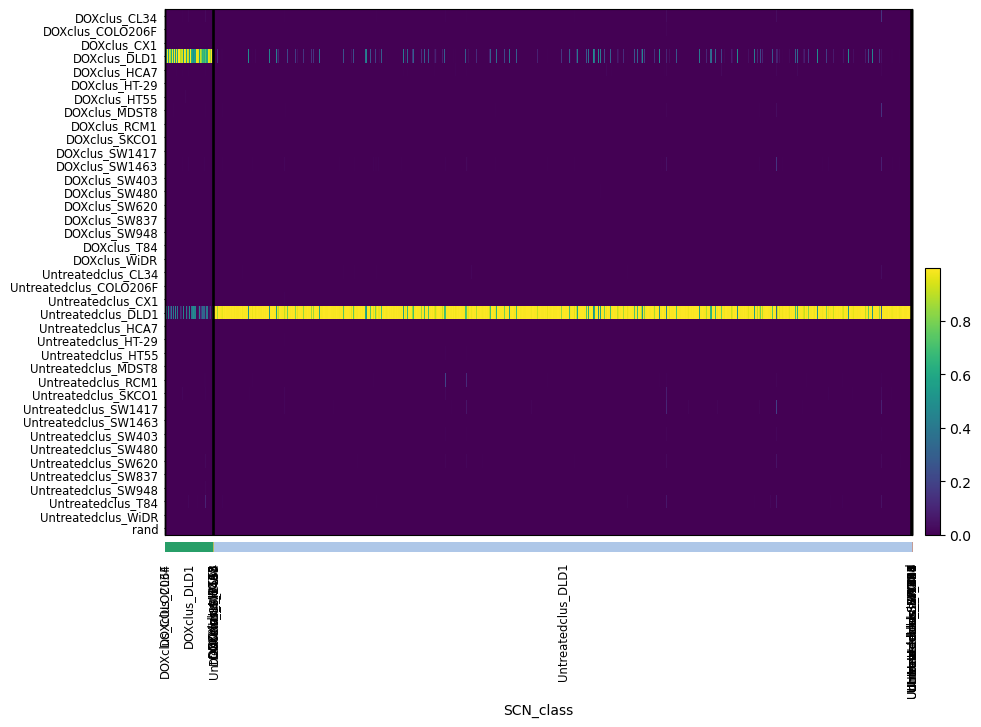

In [22]:
ax = sc.pl.heatmap(adQrf_t, adQrf_t.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

## Visualize according to the cell labels in the original study

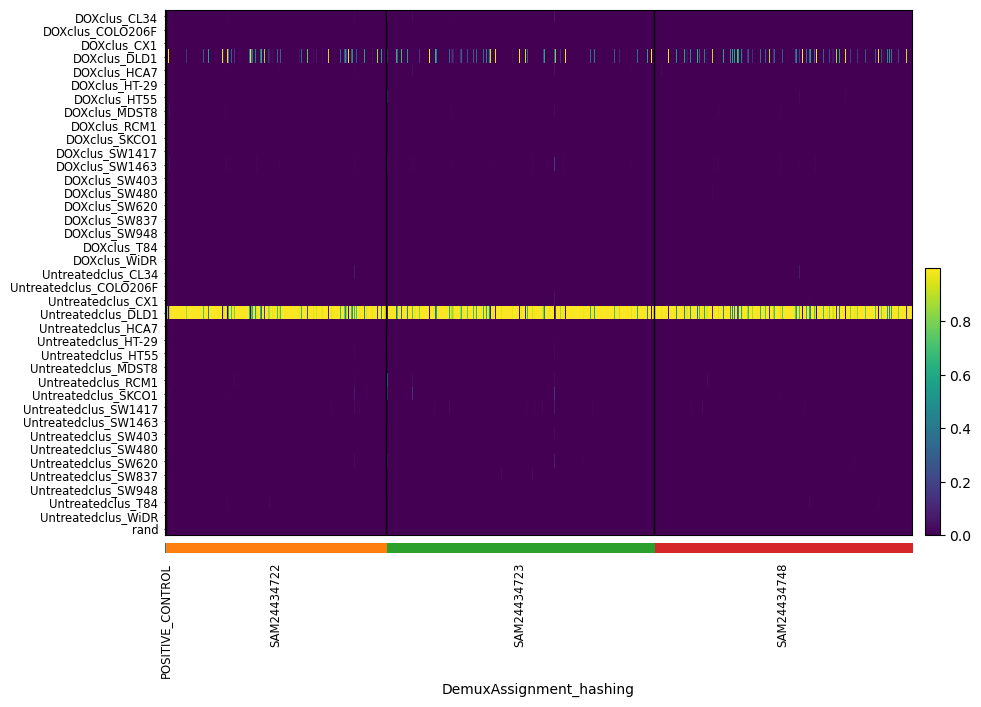

In [23]:
ax = sc.pl.heatmap(adQrf_t, adQrf_t.var_names.values, groupby=study_annotation, cmap='viridis', dendrogram=False, swap_axes=True)

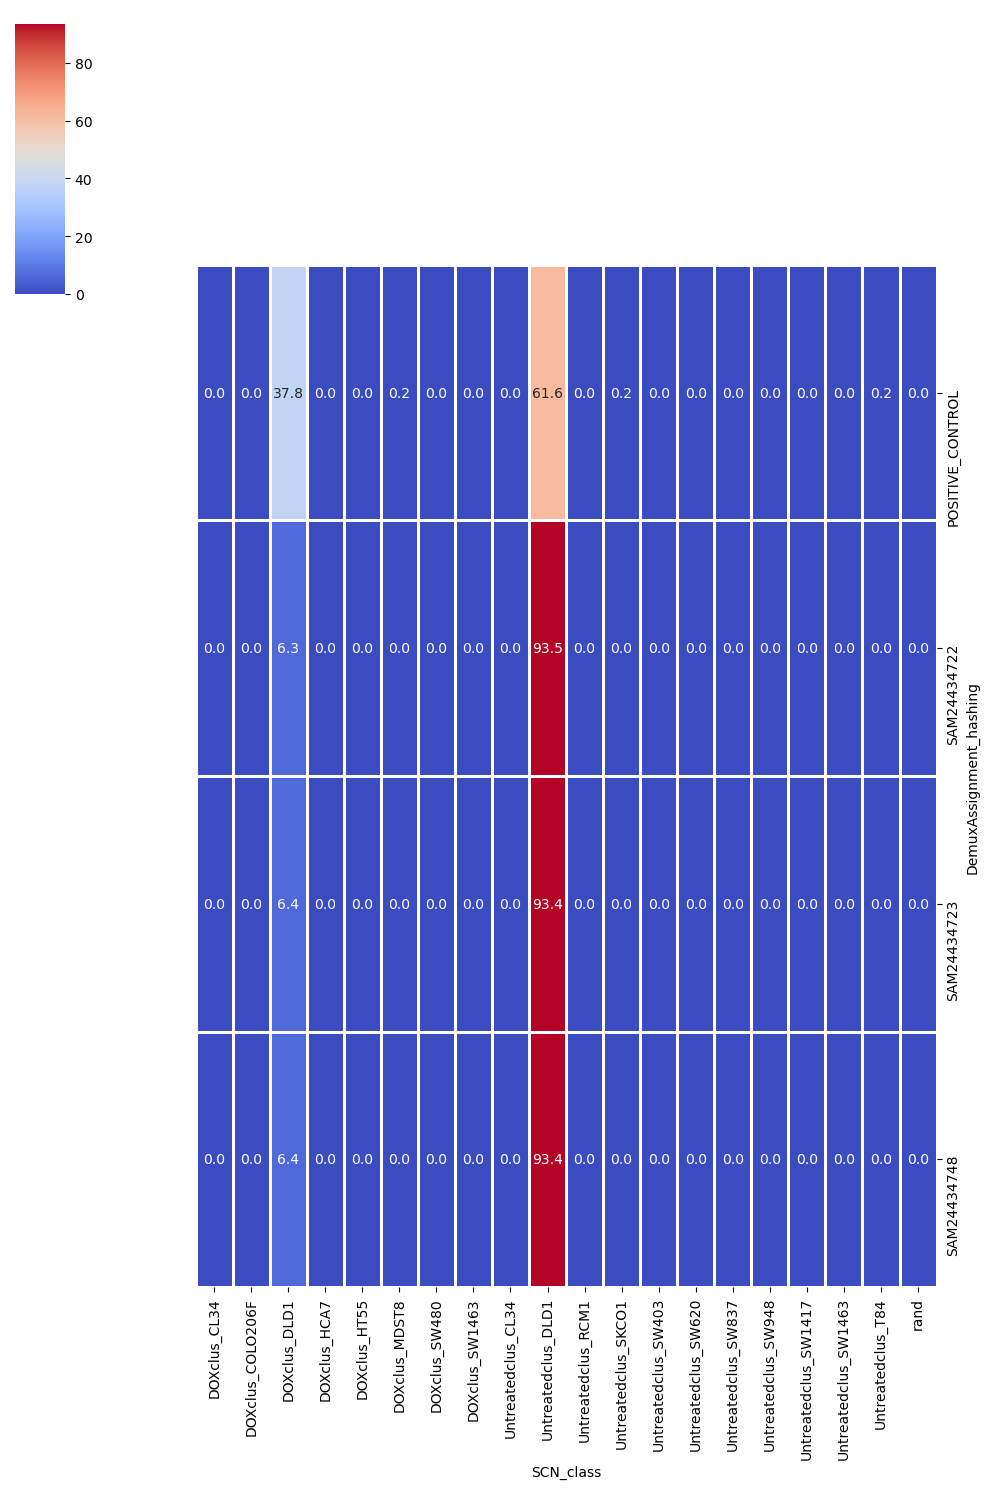

In [24]:
scn.plot_cm(scn.matrix_study_label(adQrf_t, study_annotation, 'SCN_class'), figsize=(10,15))

## Add the classification result to the query annData object

pySingleCellNet adds the SCN scores as well as the softmax classification (i.e. a label corresponding to the cell type with the maximum SCN score -- this goes in adata.obs["SCN_class"]).adQuery is your original query object, while adQrf is an anndata object with the classification stores. Save this adQrf object

In [25]:
#cp_cols=['SCN_class', 'max_val_classifier', col_proba, 'margin', col_margin]
#adQuery.obs[cp_cols] = adQrf.obs[cp_cols].copy()
adQuery.obs['SCN_class'] = adQrf_t.obs['SCN_class'].copy()

In [26]:
adQuery

AnnData object with n_obs × n_vars = 321358 × 27824
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class'
    var: 'Symbol'
    uns: '.internal'
    layers: 'counts'

In [27]:
adQrf_t

AnnData object with n_obs × n_vars = 321358 × 39
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class'
    uns: 'SCN_class_colors', 'DemuxAssignment_hashing_colors'

## Write the output file

In [28]:
adQuery.write(annotated_outfile)

## Add SCN_class cloumn at the end of embeddings object and store back

In [6]:
#adQuery = sc.read_h5ad(annotated_outfile)
raw_qc_ad = sc.read_h5ad(raw_qc)

In [30]:
raw_qc_ad.obs['SCN_class'] = adQuery.obs['SCN_class'].copy()

In [31]:
raw_qc_ad.write(raw_qc)

## Count cells and class

Only showing the first 20

In [32]:
cnts = adQrf_t.obs.groupby([study_annotation, 'SCN_class'])['SCN_class'].count().reset_index(name='cnt').sort_values(by='cnt', ascending=False)
cnts = cnts[cnts['cnt']>0]

In [33]:
cnts[:20]

,DemuxAssignment_hashing,SCN_class,cnt
49,SAM24434723,Untreatedclus_DLD1,107689
69,SAM24434748,Untreatedclus_DLD1,103486
29,SAM24434722,Untreatedclus_DLD1,88573
42,SAM24434723,DOXclus_DLD1,7432
62,SAM24434748,DOXclus_DLD1,7113
22,SAM24434722,DOXclus_DLD1,6006
9,POSITIVE_CONTROL,Untreatedclus_DLD1,307
2,POSITIVE_CONTROL,DOXclus_DLD1,188
50,SAM24434723,Untreatedclus_RCM1,42
47,SAM24434723,DOXclus_SW1463,40


## Matrixplot visualization

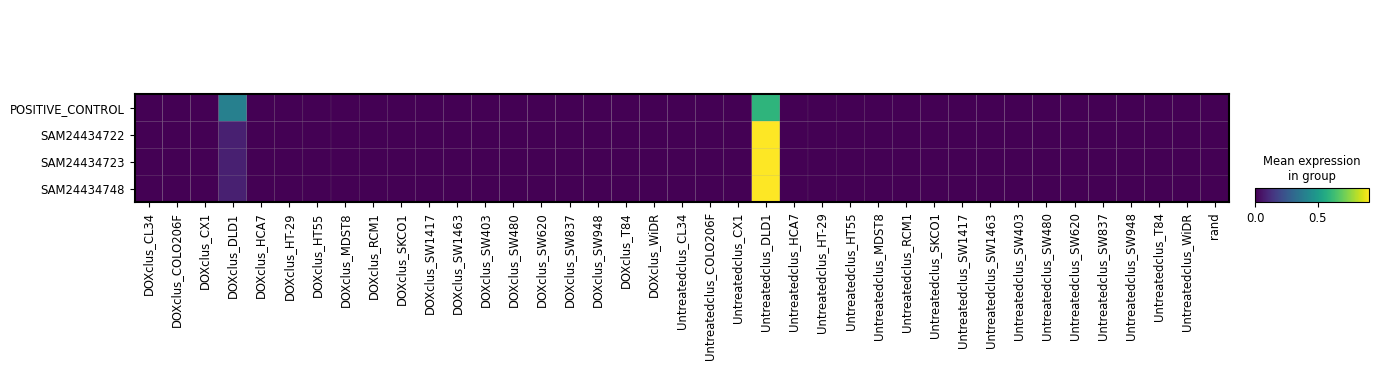

In [34]:
sc.pl.matrixplot(adQrf_t, var_names=adQrf_t.var_names, groupby=study_annotation)

## UMAP Visualiaztion

In [7]:
import Templates.tools.rapids_modified as rp

[rank: 0] Global seed set to 0


In [8]:
RP = rp.RapidsSingleCellPipeline(adQuery)

In [9]:
RP.proc(3000, norm=True, scale=True, regress=False, embedding=True,
                 n_components=50, n_neighbors=10, knn_n_pcs=30, batch_key=None, filtered= False)

starting with 321358 cells
Filtering cells.
Processed 0 cells..
Processed 100000 cells..
Processed 200000 cells..
Processed 300000 cells..
Filtering genes.
Completed preprocessing.
Now 321358 cells after filtering max genes 
Now 321358 cells after filtering pct mt 
Now 321358 cells after filtering total counts 
Preprocessing took 93.63295555114746 seconds
normalizing
Processed 0 cells..
Processed 100000 cells..
Processed 200000 cells..
Processed 300000 cells..
normalizing data.
Completed preprocessing.
Preprocessing took 43.02676177024841 seconds
selecting highly variable genes
Filtering to highly variable genes.
Processed 0 genes..
Processed 1200 genes..
Processed 2400 genes..
Processed 3600 genes..
Processed 4800 genes..
Processed 6000 genes..
Processed 7200 genes..
Processed 8400 genes..
Processed 9600 genes..
Processed 10800 genes..
Processed 12000 genes..
Processed 13200 genes..
Processed 14400 genes..
Processed 15600 genes..
Processed 16800 genes..
Processed 18000 genes..
Process

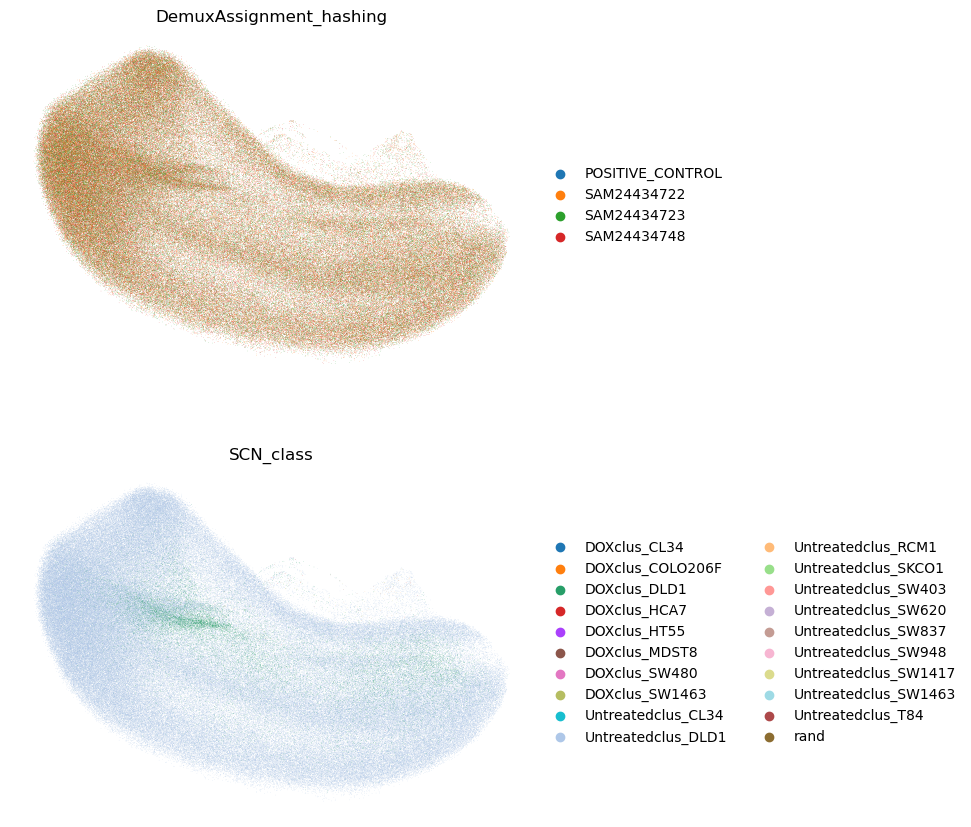

In [10]:
sc.pl.umap(RP.adata, color=['DemuxAssignment_hashing', 'SCN_class'], ncols=1, frameon=False, cmap=plt.get_cmap('viridis'))